In [1]:
import re
import spacy
import pandas as pd
from nltk.corpus import stopwords
from collections import Counter

nlp = spacy.load(
    "en_core_web_lg"
)
df = pd.read_csv("../train_all_tasks.csv")

In [2]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

lista_tekst = df["text"]
lista_label = df["label_sexist"]

for train_index, test_index in sss.split(lista_tekst, lista_label):
    X_train, X_test = lista_tekst[train_index], lista_tekst[test_index]
    y_train, y_test = lista_label[train_index], lista_label[test_index]
    d_train = {"text": X_train, "label": y_train}
    df_train = pd.DataFrame(d_train)
    d_test = {"text": X_test, "label": y_test}
    df_test = pd.DataFrame(d_test)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.125, random_state=42)

lista_tekst = np.array(df_train["text"])
lista_label = np.array(df_train["label"])

for train_index, valid_index in sss.split(lista_tekst, lista_label):
    X_train, X_valid = lista_tekst[train_index], lista_tekst[valid_index]
    y_train, y_valid = lista_label[train_index], lista_label[valid_index]
    d_train = {"text": X_train, "label": y_train}
    df_train = pd.DataFrame(d_train)
    d_valid = {"text": X_valid, "label": y_valid}
    df_valid = pd.DataFrame(d_valid)

print("Train labels:", len(df_train))
print("Valid labels:", len(df_valid))
print("Test labels: ", len(df_test))

Train labels: 9800
Valid labels: 1400
Test labels:  2800


In [3]:
from gensim.models import KeyedVectors
from gensim import models
from gensim.utils import simple_preprocess

word2vec_path = '../GoogleNews-vectors-negative300.bin'

load_only = False
if load_only:
    model = models.KeyedVectors.load('vectors.kv')
else:
    model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary = True, unicode_errors='replace')

In [4]:
def W2Vvectorize(train):
    corpus_text = '\n'.join(train)
    sentences = corpus_text.split('\n')
    sentences = [line.lower().split(' ') for line in sentences]

    def clean(s):
        return [w.strip(',."!?:;()\'') for w in s]

    sentences = [clean(s) for s in sentences if len(s) > 0]
    vector=[]
    for sent in sentences:
        sent_vec=np.zeros(300)
        count =0
        for word in sent: 
            if word in model:
                vec = model[word]
                sent_vec += vec 
                count += 1
        if count != 0:
            sent_vec /= count #normalize
        vector.append(sent_vec)
    return vector

In [5]:
def evaluate(model, text, y_test, target_names=('not sexist', 'sexist')):
    import matplotlib.pyplot as plt
    from sklearn.metrics import classification_report
    from sklearn.metrics import ConfusionMatrixDisplay
    from sklearn.metrics import precision_recall_fscore_support

    text_features = W2Vvectorize(text)
    y_test_pred = model.predict(text_features)
    print(classification_report(y_test, y_test_pred, target_names=target_names))

    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average="micro")
    print(f"Precision: {precision:6.2f}")
    print(f"   Recall: {recall:6.2f}")
    print(f"       F1: {f1:6.2f}")

    ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=target_names)
    plt.show()

In [6]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

lista_label = np.array(df_train["label"])
lista_label = le.fit_transform(lista_label)

nova_lista = W2Vvectorize(df_train["text"])

In [7]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline

h = .02  # step size in the mesh

alphas = np.logspace(-1, 1, 5)

classifiers = []
names = []
for alpha in alphas:
    classifiers.append(make_pipeline(
        StandardScaler(),
        MLPClassifier(
            solver='lbfgs', alpha=alpha, random_state=1, max_iter=2000,
            early_stopping=True, hidden_layer_sizes=[100, 100],
        )
    ))
    names.append(f"alpha={alpha:.2f}")

lista_label_test = np.array(df_test["label"])
lista_label_test = le.fit_transform(lista_label_test)
nova_lista_test = W2Vvectorize(df_test["text"])

for name, clf in zip(names, classifiers):
    clf.fit(nova_lista, lista_label)
   
    print(str(name) + " results:")
    print("Test: " + str(clf.score(nova_lista_test,lista_label_test)))
    print("Training: " + str(clf.score(nova_lista, lista_label)))
    print('---------------------------------------------')

alpha=0.10 results:
Test: 0.7575
Training: 0.9996938775510205
---------------------------------------------
alpha=0.32 results:
Test: 0.7585714285714286
Training: 0.9996938775510205
---------------------------------------------
alpha=1.00 results:
Test: 0.7607142857142857
Training: 0.9996938775510205
---------------------------------------------
alpha=3.16 results:
Test: 0.7696428571428572
Training: 0.9996938775510205
---------------------------------------------
alpha=10.00 results:
Test: 0.7746428571428572
Training: 0.9996938775510205
---------------------------------------------


Training: 0.9996938775510205
Test:0.7746428571428572
              precision    recall  f1-score   support

  not sexist       0.83      0.88      0.85      2120
      sexist       0.54      0.46      0.50       680

    accuracy                           0.77      2800
   macro avg       0.69      0.67      0.68      2800
weighted avg       0.76      0.77      0.77      2800

Precision:   0.77
   Recall:   0.77
       F1:   0.77


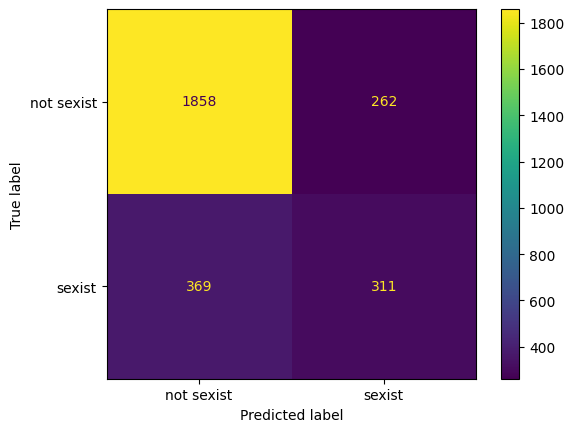

In [8]:
clf.fit(nova_lista, lista_label)

print("Training: " + str(clf.score(nova_lista, lista_label)))

lista_label_test = np.array(df_test["label"])
lista_label_test = le.fit_transform(lista_label_test)
nova_lista_test = W2Vvectorize(df_test["text"])

print("Test:" + str(clf.score(nova_lista_test,lista_label_test)))
evaluate(clf, df_test.text, lista_label_test)